In [239]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.spatial import distance
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_score

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [13]:
# test model
test_model = "/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/file_fold_4_drop_rate=0.05_HCPfull/09-47-47"

# UMAP

In [14]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [286]:
# code taken from evaluation/clustering.py

def train_AP(data_df, n_clusters, verbose=False):
    af = AffinityPropagation(random_state=None).fit(data_df)
    cluster_labels_ini = af.labels_
    initial_centers = af.cluster_centers_indices_
    n_clusters_ = len(initial_centers)
    x_cluster_label = af.predict(data_df)

    if verbose:
        print("AP initial centers:", initial_centers)
        print("Initial number of clusters", n_clusters_)
    while n_clusters_ > n_clusters:
        af = AffinityPropagation(random_state=None).fit(data_df.iloc[af.cluster_centers_indices_,:])
        center_cluster_labels = af.labels_
        x_cluster_label = af.predict(data_df)
        n_clusters_ = len(af.cluster_centers_indices_)
        if verbose:
            print("Reduced number of clusters", n_clusters_)
    
    return x_cluster_label

In [259]:
def clustering(df, clustering_method, n_clusters, verbose=False):
    if clustering_method == 'kmeans':
        true_kmeans = KMeans(n_clusters=n_clusters)
        true_clusters = true_kmeans.fit_predict(df)
    
    elif clustering_method == "AP":
        true_clusters = train_AP(df, n_clusters=n_clusters, verbose=verbose)
    
    else:
        raise ValueError("Unknown clustering method :(")
    
    return true_clusters

In [39]:
def plot_svm_predictions(umap_embs, prediction_df, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75],
                         cmap = ['b', 'r'], verbose=False):
    # plot for predicted labels
    n_i = len(quantiles)
    n_j = len(thresholds)
    plt.figure(figsize=(n_i*6.4, n_j*4.8))
    
    for i,quantile in enumerate(quantiles):
        svm_model, model_auc = get_model_by_quality(prediction_df, q=quantile)
        model_auc = "{:.2f}".format(model_auc)
        if verbose:
            print(f"Chosen svm model for quantile {quantile} (ie auc={model_auc}):")
        
        for j,threshold in enumerate(thresholds):
            plt.subplot(n_i, n_j, i*n_j + j + 1)
            
            mid_svm_pred = (prediction_df[svm_model] >= threshold).astype(int)
            if verbose:
                print(mid_svm_pred[:5])
                print("shape:", mid_svm_pred.shape)

            colors = [cmap[i] for i in mid_svm_pred]
            """if show_wrong_class:
                colors = []
                for i in range(prediction_df.shape[0]):
                    if prediction_df[la]"""

            plt.scatter(umap_embs[:,0], umap_embs[:,1], c=colors, alpha=0.6)
            if i == n_i-1:
                plt.xlabel(f"Decision threshold = {threshold}")
            if j == 0:
                plt.ylabel(f"Model quality={quantile} (auc={model_auc})")
            # compute accuracy
            accuracy = ((prediction_df[svm_model] >= threshold) == prediction_df.label).astype(float).mean()
            plt.title("Svm labels ; accuracy = {:.2f}".format(accuracy))
    plt.show()

In [262]:
def full_visualization(model_path, clustering_method="kmeans", n_clusters=4, quantiles=[0,0.5,1],
                       thresholds=[0.25,0.5,0.75], verbose=False):
    
    ## plot the svm curves
    plt.figure(figsize=(10, 7.5))
    fig = plt.imshow(mpimg.imread(model_path+"/cingulate_ACCpatterns_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    # give the model auc?


    ## compute the clusters on the embeddings
    # load the data
    data_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)
    if verbose:
        print("Data df:")
        print(data_df[:5])

    true_clusters = clustering(data_df, clustering_method, n_clusters, verbose=verbose)


    ## apply umap
    reducer = umap.UMAP()
    umap_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(umap_embs.shape)
        print(umap_embs[:5])
    

    ## apply kmeans on the UMAP data
    umap_clusters = clustering(pd.DataFrame(umap_embs), clustering_method, n_clusters, verbose=verbose)
    

    ## plot the umaps
    # plot the clusters
    plt.figure()
    plt.scatter(umap_embs[:,0], umap_embs[:,1], c=true_clusters, alpha=0.6)
    plt.title(f"Clusters before umap (method={clustering_method})")
    plt.show()

    plt.figure()
    plt.scatter(umap_embs[:,0], umap_embs[:,1], c=umap_clusters, alpha=0.6)
    plt.title(f"Clusters after umap (method={clustering_method})")
    plt.show()

    # load the predictions
    prediction_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)
    if verbose:
        print("Prediction df:")
        print(prediction_df[:5])
    
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(umap_embs[:,0], umap_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()

    # plot the svm predictions
    plot_svm_predictions(umap_embs, prediction_df, quantiles=quantiles, thresholds=thresholds,
                         cmap=cmap, verbose=verbose)
    

    ## generate the result df
    res_df = pd.DataFrame(umap_embs, index=data_df.index, columns=['umap0', 'umap1'])
    res_df['true_labels'] = prediction_df.label
    res_df['true_cluster'] = true_clusters
    res_df['umap_clusters'] = umap_clusters

    return res_df

/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibito

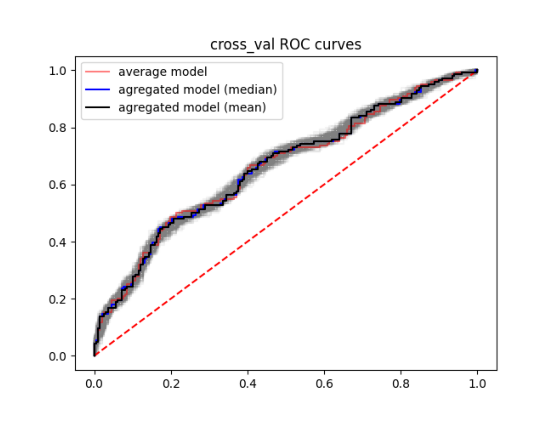

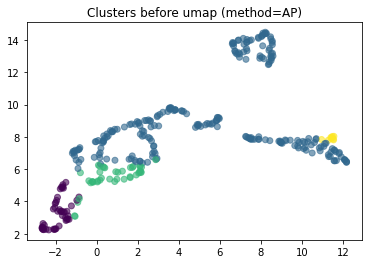

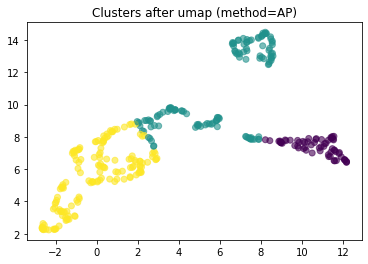

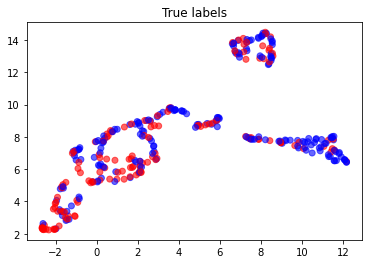

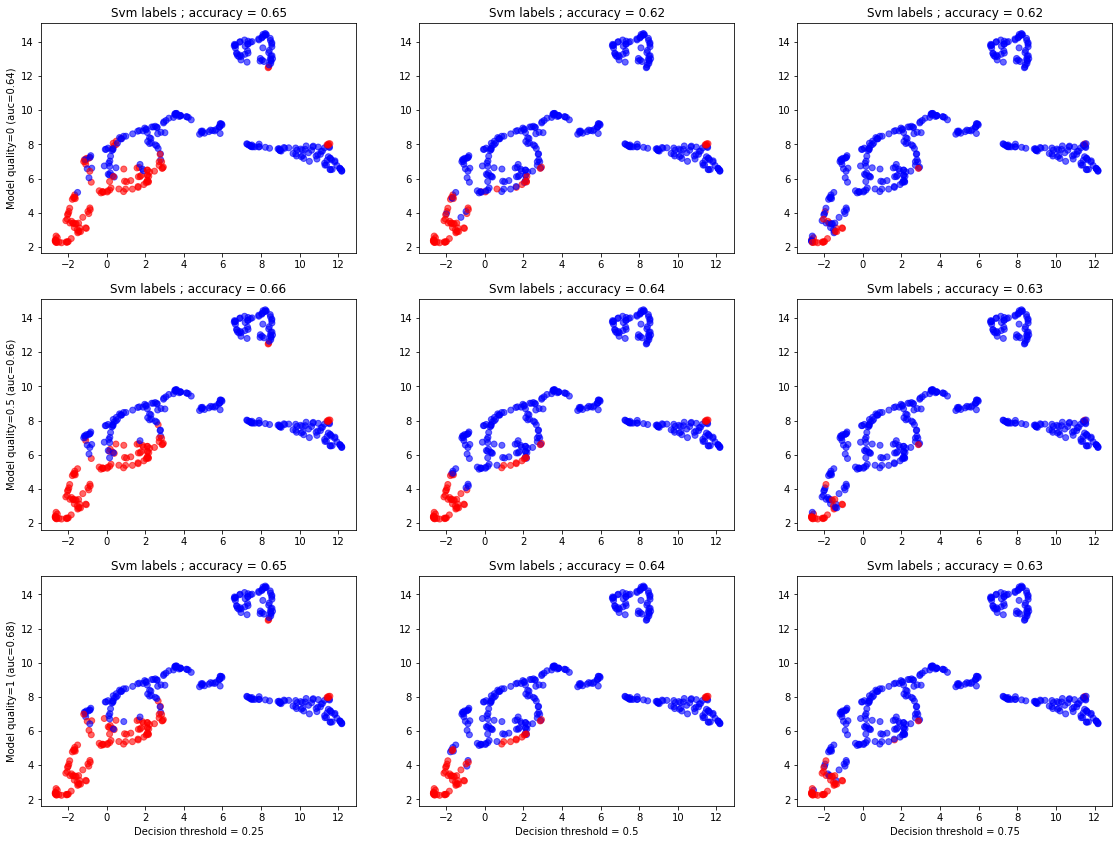

In [265]:
# test model
res_df = full_visualization(test_model, clustering_method='AP', n_clusters=6)

## Choose relevent SimCLR models

In [18]:
bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models.csv", index_col=0)
bdd.sort_values(by='auc', ascending=False, inplace=True)
bdd

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
116,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,0.669267,0.009264,pointnet,16,0.15,100,True,...,30,30,0.5,0.5,4.367986,4.052493,False,-0.430873,cingulate_HCP_half_1,pointnet
75,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.693590,0.051831,0.619449,0.052646,densenet,16,0.05,100,True,...,30,30,0.1,0.1,0.762840,1.369004,False,0.757828,cingulate_HCP_half_1,Run_03_aymeric
25,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.692153,0.049598,0.629595,0.054254,densenet,16,0.15,100,True,...,30,30,0.1,0.1,1.032371,2.509686,False,0.683913,cingulate_HCP_half_1,Run_03_aymeric
91,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,0.668692,0.007873,pointnet,16,0.05,100,True,...,30,30,0.1,0.1,1.336895,2.419318,False,-0.361733,cingulate_HCP_half_1,pointnet
12,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.678640,0.044072,0.634545,0.037935,convnet,16,0.15,100,False,...,30,30,0.1,0.1,0.263586,0.195343,False,-0.301107,cingulate_HCP_half_1,Run_03_aymeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.480352,0.022429,0.549314,0.014923,NaN,16,0.15,100,False,...,4,4,0.1,0.1,6.815775,6.824551,structure,NaN,cingulate_HCP_half_1,Run_43_joel
100,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.478818,0.022703,0.576880,0.003572,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,5.256860,5.389712,False,0.129245,cingulate_HCP_half_1,pointnet
19,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.473885,0.042166,0.510393,0.050783,convnet,16,0.15,100,False,...,4,4,0.1,0.1,8.022524,6.433455,bad_learning,0.943119,cingulate_HCP_half_1,Run_03_aymeric
38,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.466274,0.034258,0.547683,0.020623,densenet,16,0.15,100,False,...,4,4,0.1,0.1,3.534628,3.446562,False,-0.106718,cingulate_HCP_half_1,Run_03_aymeric


In [19]:
best_model = bdd.iloc[0,:]
best_model = best_model.model_path
print(best_model)

worst_model = bdd.iloc[-1,:]
worst_model = worst_model.model_path
print(worst_model)

/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/fold_30_T=0.5
/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/no_4_drop_rate=0.05


/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibito

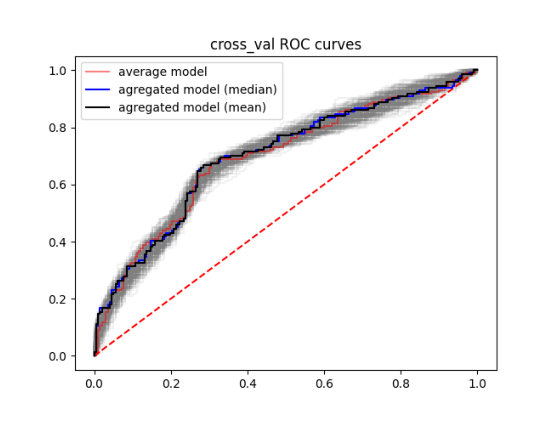

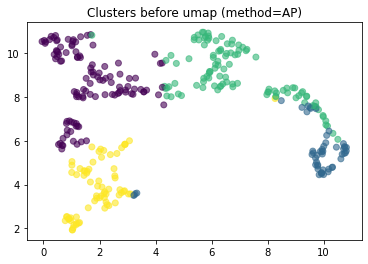

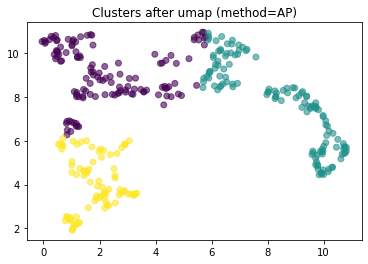

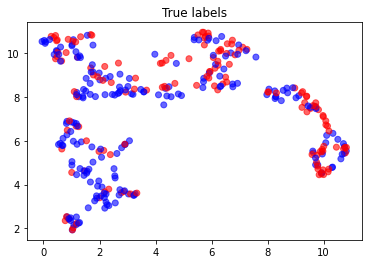

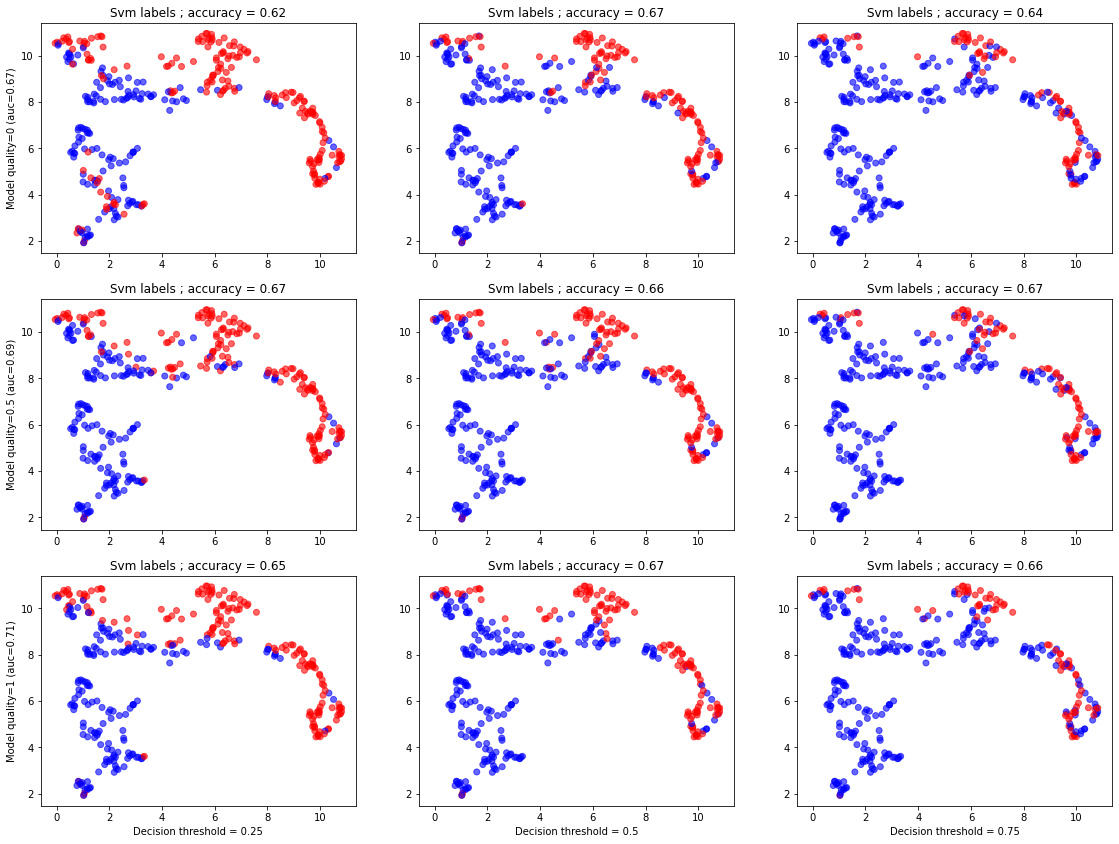

,umap0,umap1,true_labels,true_cluster,umap_clusters
ID,,,,,
1-03HUBJO_t0,9.974550,5.526057,1,1,1
1-08ANDTI_t0,6.234543,9.458865,1,2,1
1-11LEBJO_t0,6.121737,9.321898,1,2,1
1-15LEHMI_t0,1.766554,10.380086,0,0,0
1-17COLMA_t0,2.557993,4.302527,0,3,2
...,...,...,...,...,...
sub-inhibition25_ses-pretraining_T1w,0.430388,10.817277,1,0,0
sub-inhibition26_ses-pretraining_T1w,0.220370,10.633566,0,0,0
sub-inhibition28_ses-pretraining_T1w,2.165474,3.601620,0,3,2


In [231]:
best_model_df = full_visualization(best_model, clustering_method='AP', n_clusters=6)
best_model_df

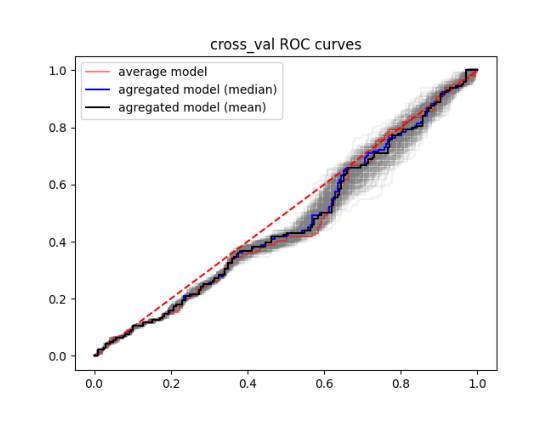

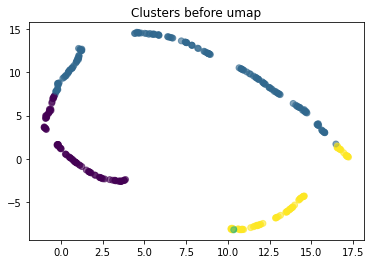

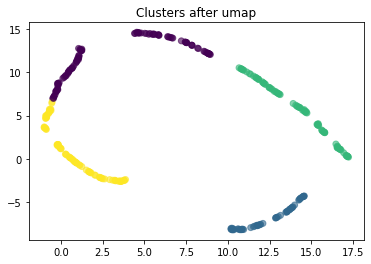

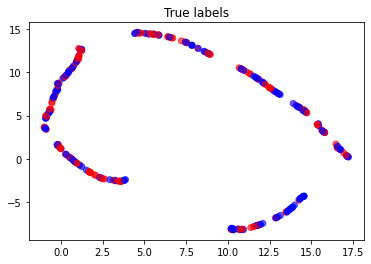

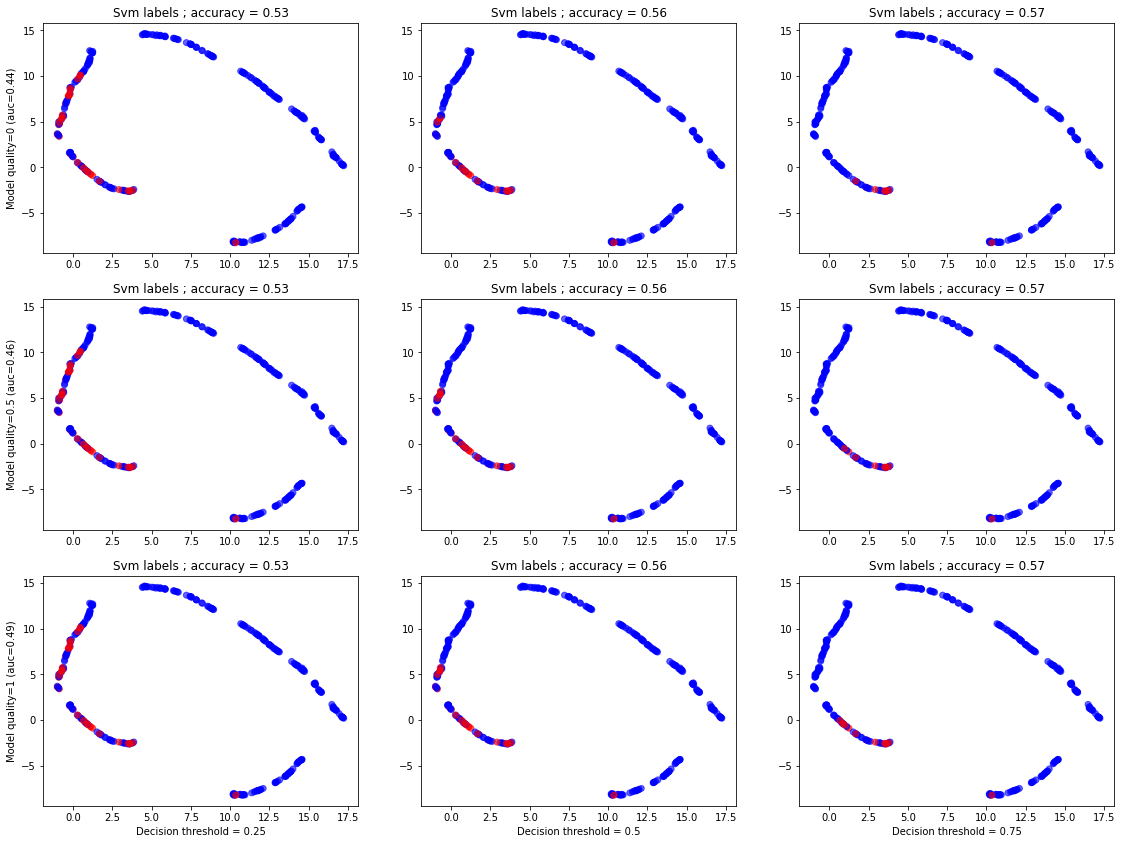

,umap0,umap1,true_labels,true_cluster,umap_clusters
ID,,,,,
1-03HUBJO_t0,7.450698,13.527031,1,1,0
1-08ANDTI_t0,14.708471,5.457958,1,1,2
1-11LEBJO_t0,14.069140,6.215641,1,1,2
1-15LEHMI_t0,12.919815,-6.802500,0,3,1
1-17COLMA_t0,14.477120,-4.421797,0,3,1
...,...,...,...,...,...
sub-inhibition25_ses-pretraining_T1w,10.889812,-8.143270,1,3,1
sub-inhibition26_ses-pretraining_T1w,14.587399,-4.307145,0,3,1
sub-inhibition28_ses-pretraining_T1w,3.795684,-2.482701,0,0,3


In [52]:
full_visualization(worst_model)

### Select other interesting models

High variance models

In [20]:
filtered_bdd = bdd[bdd.auc_std >= 0.05]
filtered_bdd

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
75,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.693590,0.051831,0.619449,0.052646,densenet,16,0.05,100,True,...,30,30,0.10,0.1,0.762840,1.369004,False,0.757828,cingulate_HCP_half_1,Run_03_aymeric
76,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.670914,0.051652,0.596364,0.056285,densenet,16,0.05,100,True,...,30,30,0.10,0.1,1.159750,2.443445,False,0.812578,cingulate_HCP_half_1,Run_03_aymeric
24,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.668507,0.053301,0.601525,0.057313,densenet,16,0.15,100,True,...,30,30,0.10,0.1,0.728199,1.858723,False,0.753235,cingulate_HCP_half_1,Run_03_aymeric
78,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668161,0.050466,0.598956,0.053273,densenet,16,0.05,100,True,...,30,30,0.10,0.1,1.041767,1.704926,False,0.781419,cingulate_HCP_half_1,Run_03_aymeric
22,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.627084,0.052677,0.577161,0.053945,densenet,16,0.15,100,True,...,30,30,0.10,0.1,1.329955,3.381569,False,0.642852,cingulate_HCP_half_1,Run_03_aymeric
47,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.626335,0.050238,0.598792,0.041902,convnet,16,0.15,100,False,...,30,30,0.01,0.1,0.172071,0.144276,False,-0.318485,cingulate_HCP_half_1,Run_03_aymeric
72,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.593398,0.056054,0.585232,0.040975,convnet,16,0.05,100,True,...,30,30,0.50,0.5,3.714237,3.622833,False,-0.285862,cingulate_HCP_half_1,Run_03_aymeric
5,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.581583,0.057815,0.562100,0.052206,convnet,16,0.15,100,True,...,4,4,0.10,0.1,4.480739,2.831487,False,-0.022561,cingulate_HCP_half_1,Run_03_aymeric
67,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.576889,0.056377,0.567038,0.039782,convnet,16,0.15,100,False,...,30,12,0.50,0.5,4.367877,3.828899,mismatch,NaN,cingulate_HCP_half_1,Run_03_aymeric
43,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.574575,0.063551,0.555718,0.051553,convnet,16,0.15,100,True,...,4,4,0.10,0.1,4.664048,4.961831,False,0.286409,cingulate_HCP_1mm,Run_03_aymeric


In [53]:
high_variance_good = filtered_bdd.iloc[0,:].model_path
high_variance_bad = filtered_bdd.iloc[-1,:].model_path

/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibito

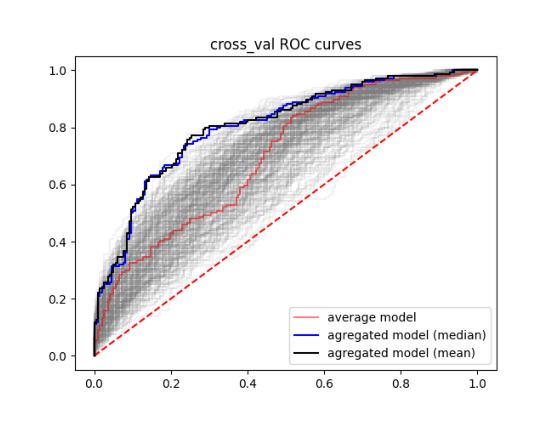

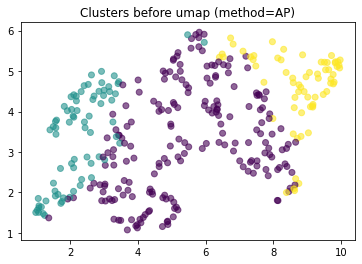

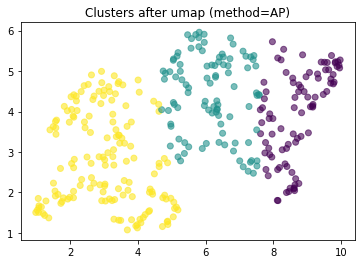

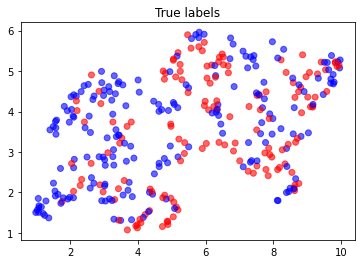

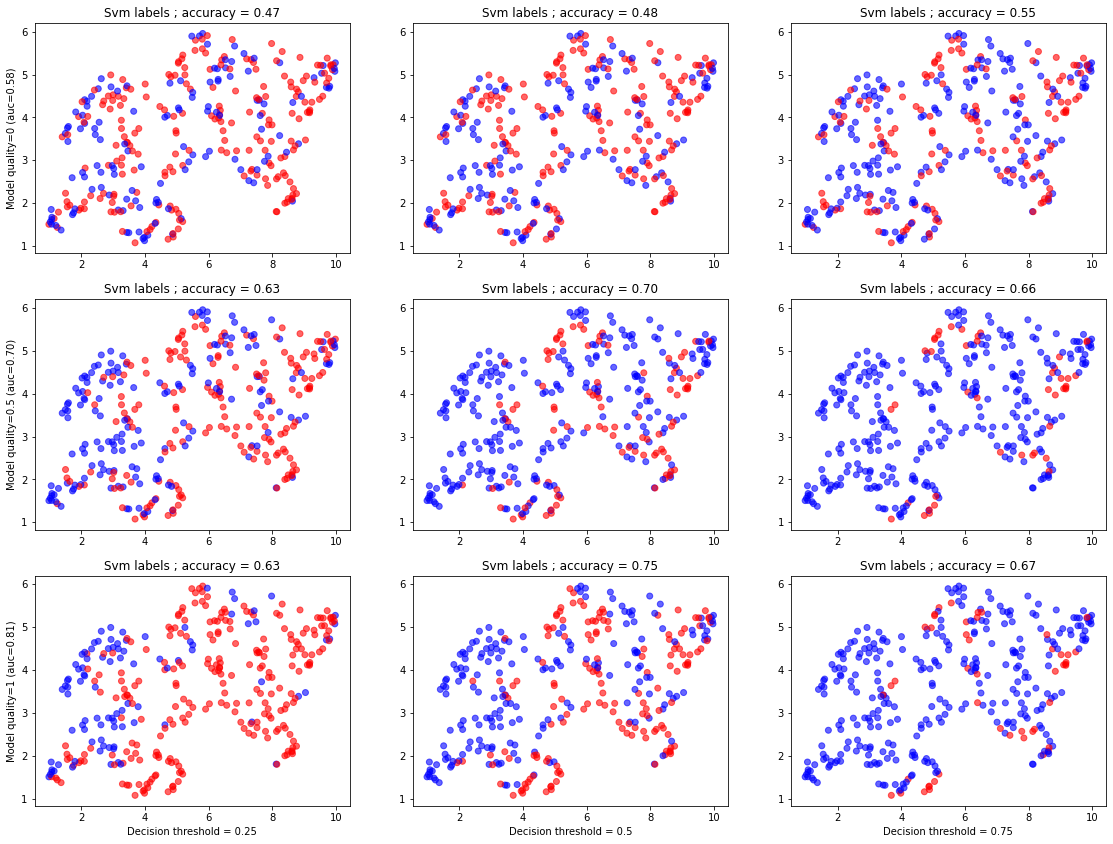

,umap0,umap1,true_labels,true_cluster,umap_clusters
ID,,,,,
1-03HUBJO_t0,4.885552,1.208927,1,0,2
1-08ANDTI_t0,3.260701,3.741886,1,1,2
1-11LEBJO_t0,3.679457,3.633840,1,0,2
1-15LEHMI_t0,4.433597,1.956863,0,0,2
1-17COLMA_t0,4.624676,2.720492,0,0,2
...,...,...,...,...,...
sub-inhibition25_ses-pretraining_T1w,9.164488,4.138471,1,2,0
sub-inhibition26_ses-pretraining_T1w,9.176643,4.175676,0,2,0
sub-inhibition28_ses-pretraining_T1w,8.141949,1.798883,0,0,0


In [234]:
best_densenet_df = full_visualization(high_variance_good, clustering_method='AP', n_clusters=4)
best_densenet_df

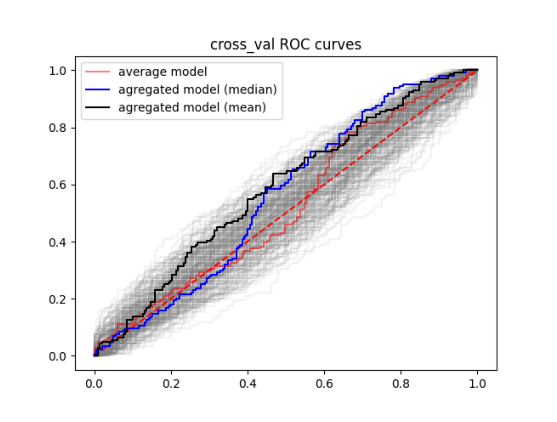

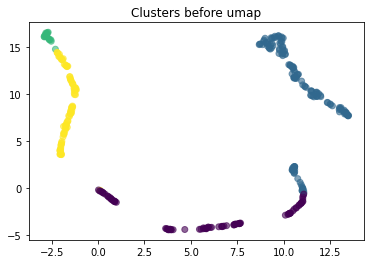

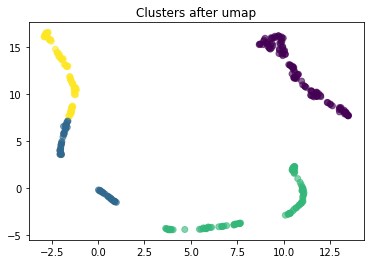

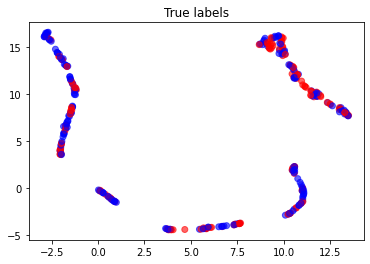

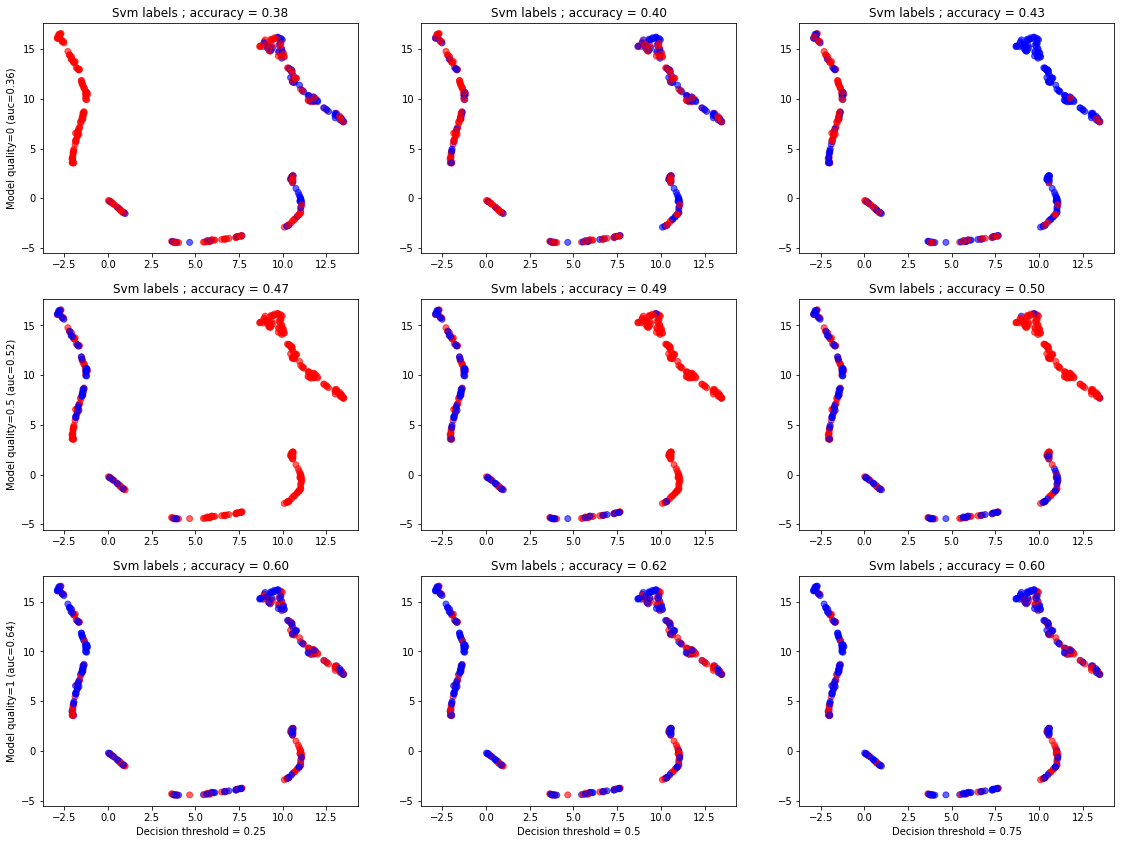

,umap0,umap1,true_labels,true_cluster,umap_clusters
ID,,,,,
1-03HUBJO_t0,12.524666,8.864223,1,1,0
1-08ANDTI_t0,-2.003490,3.735979,1,3,1
1-11LEBJO_t0,10.474080,2.098395,1,1,2
1-15LEHMI_t0,0.893644,-1.404156,0,0,1
1-17COLMA_t0,5.461426,-4.413051,0,0,2
...,...,...,...,...,...
sub-inhibition25_ses-pretraining_T1w,9.321561,15.992281,1,1,0
sub-inhibition26_ses-pretraining_T1w,9.585983,16.038668,0,1,0
sub-inhibition28_ses-pretraining_T1w,5.931217,-4.177302,0,0,2


In [55]:
full_visualization(high_variance_bad)

## Visualize cluster "centroids"

In [252]:
def get_centroid(embs, i_cluster, coord_cols=[]):
    if coord_cols == []:
        coord_cols = embs.columns

    cluster = embs[embs.true_cluster == i_cluster]
    centroid = cluster[coord_cols].mean()

    return centroid.values

In [253]:
def closest_to_centroid(df, centroid, coord_cols=[]):
    if coord_cols == []:
        coord_cols = df.columns

    distances = df[coord_cols].apply(distance.euclidean, v=centroid, axis=1)
    distances_df = pd.DataFrame(distances, index=df.index, columns=['dist'])
    return distances_df[distances_df.dist == distances.min()]

In [254]:
# bad, as centroids are computed on the umap embeddings
def get_and_plot_closests(df, cmap='Set2'):
    plt.figure()
    cmap = plt.get_cmap(cmap)

    closests = []

    i_clusters = df.true_cluster.sort_values().unique()

    for i in i_clusters:
        cluster = df[df.true_cluster == i]
        plt.scatter(cluster.umap0, cluster.umap1, color=cmap(i),
                    alpha=0.6)

        centroid = get_centroid(df, i, coord_cols=['umap0', 'umap1'])
        plt.plot(centroid[0], centroid[1], color=cmap(i),
                 marker='*', mec='black', ms=10)
        
        closest = closest_to_centroid(cluster, centroid, coord_cols=['umap0', 'umap1'])
        closest = cluster.loc[closest.index,:]
        plt.plot(closest.umap0, closest.umap1, color=cmap(i),
                 marker='o', mec='black')
        
        closests.append(closest.index)

    plt.show()

    return closests

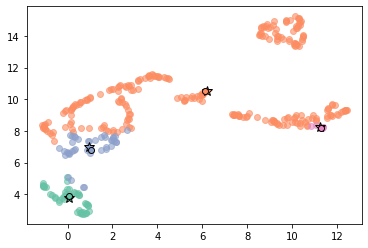

[Index(['nih_chp_03811_t1'], dtype='object', name='ID'),
 Index(['a0006_t1_s03'], dtype='object', name='ID'),
 Index(['e0059_t1_s03'], dtype='object', name='ID'),
 Index(['sub-inhibition28_ses-pretraining_T1w'], dtype='object', name='ID')]

In [256]:
get_and_plot_closests(res_df)

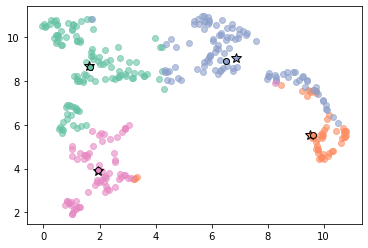

[Index(['nih_chp_04766_t1'], dtype='object', name='ID'),
 Index(['e0066_t1_s03'], dtype='object', name='ID'),
 Index(['nih_chp_02488_t1'], dtype='object', name='ID'),
 Index(['sub-active02_ses-pretraining_T1w'], dtype='object', name='ID')]

In [257]:
get_and_plot_closests(best_model_df)

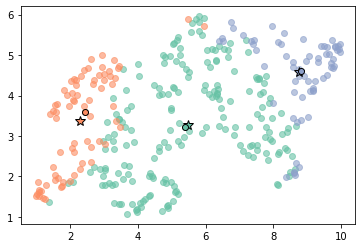

[Index(['sub-inhibition15_ses-pretraining_T1w'], dtype='object', name='ID'),
 Index(['nih_chp_04809_t1'], dtype='object', name='ID'),
 Index(['a0025_t1_s03'], dtype='object', name='ID')]

In [258]:
get_and_plot_closests(best_densenet_df)

## Clustering methods comparison

In [283]:
def compare_clustering_methods(model_path, methods=['kmeans', 'AP'],
    Ns=range(2,11), verbose=False):

    # load the data
    data_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)
    if verbose:
        print("Data df:")
        print(data_df[:5])
    
    ## apply umap
    reducer = umap.UMAP()
    umap_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(umap_embs.shape)
        print(umap_embs[:5])


    ## loop over the clustering methods and parameters
    for method in methods:
        for n_clusters in Ns:
            print(method, n_clusters)

            clusters = clustering(data_df, method, n_clusters)
            
            silh_score = silhouette_score(data_df, clusters)
            print(silh_score)

            plt.figure()
            plt.scatter(umap_embs[:,0], umap_embs[:,1], c=clusters, alpha=0.6)
            plt.title(f"{method}, n = {n_clusters}, " + "silhouette score = {:.2f}".format(silh_score))
            plt.show()

    # for each model x condition do
    #   do the clustering
    #   compute the centroid
    #   get the closest to centroids
    #   compute silhouette score
    #   plot the clusters 

kmeans 2
0.3214952517798337


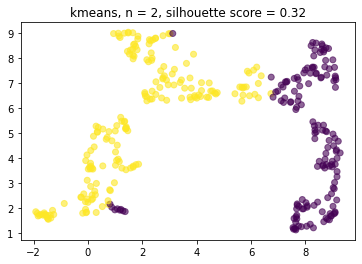

kmeans 3
0.367226835958536


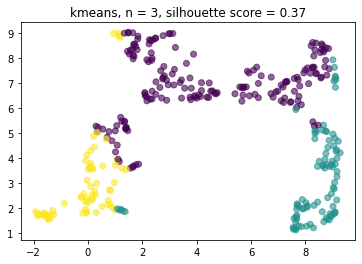

kmeans 4
0.3932691895580512


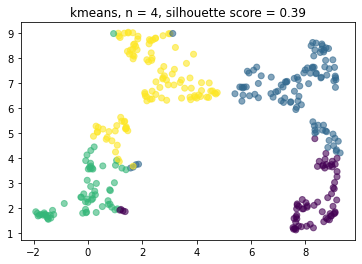

kmeans 5
0.37260525021961816


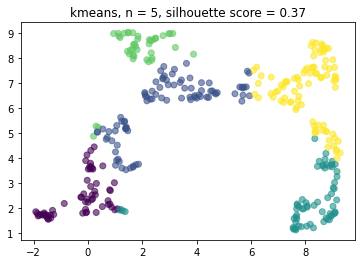

kmeans 6
0.3661130491446001


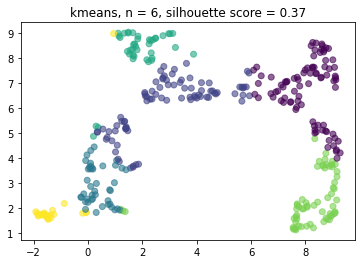

kmeans 7
0.34403285556822283


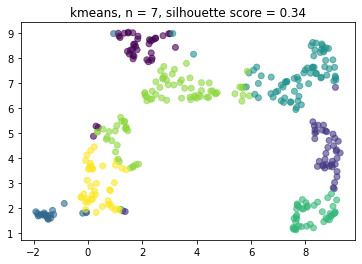

kmeans 8
0.34969308987007625


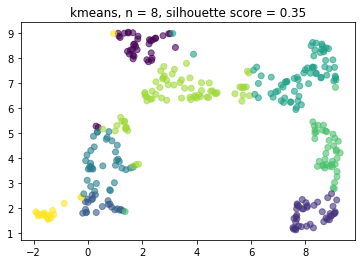

kmeans 9
0.3325693267777941


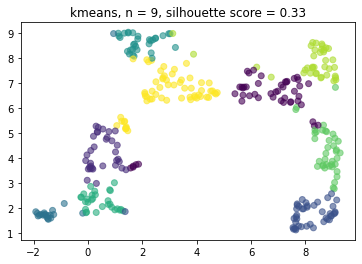

kmeans 10
0.3308479149708199


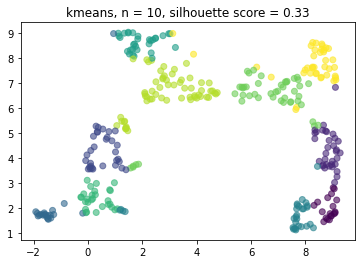

AP 2
0.2882057340948437


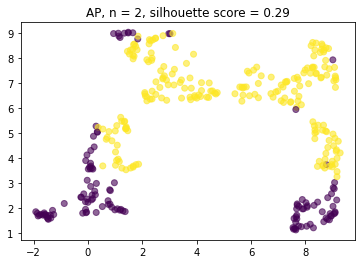

AP 3
0.2882057340948437


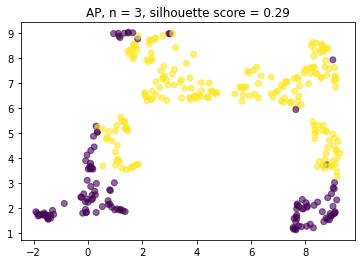

AP 4
0.3818141966006937


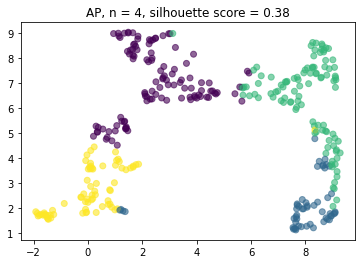

AP 5
0.3818141966006937


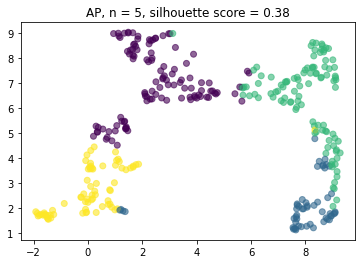

AP 6
0.3818141966006937


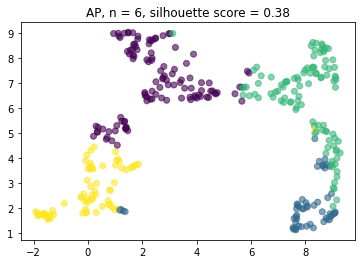

AP 7
0.3818141966006937


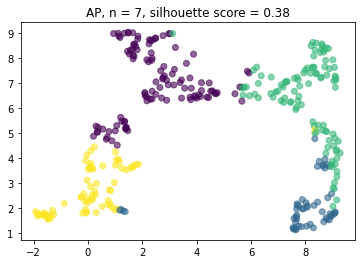

AP 8
0.3818141966006937


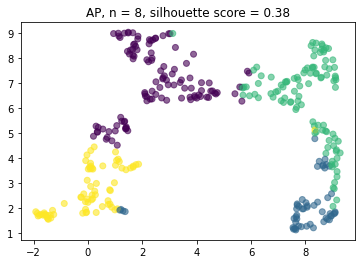

AP 9
0.3818141966006937


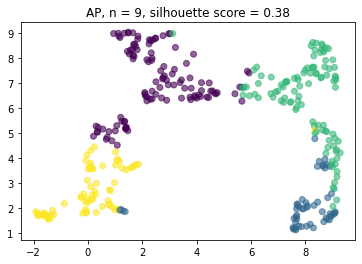

AP 10
0.3818141966006937


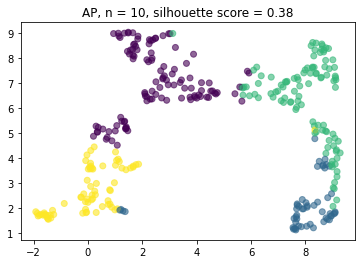

In [289]:
compare_clustering_methods(best_model, Ns=range(2,11))